# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import sys

In [53]:
#Reading in the full CSV created in EDA
full = pd.read_csv('../Data/full.csv')
full.drop(columns=['Unnamed: 0'], inplace=True)

In [54]:
#Creating a lemmatizer function to use in parameters later
def lemmatize_reddit(doc):
    split_doc = doc.split()
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(i) for i in split_doc])     

# CountVectorizer Combos

In [5]:
#Setting X y
X = full['all_text']
y = full['subreddit']

#Train-Test-Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

In [38]:
#Looking at baseline score to beat
baseline = 1 - y.mean()
baseline

0.4568403908794788

In [7]:
#Creating stopwords
sw = stopwords.words('english') + ['https', 'http', 'www', 'wiki', 'reddit', 'com', 'faq']

#Instantiating CountVectorizer
cvec = CountVectorizer(stop_words=sw, ngram_range=(1,2))

#Creating a Pipeline to preprocess X and y
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

#Fitting the data to the pipeline and getting accuracy score
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9699601882012305, 0.9457111834961998)

In [8]:
#Creating hyper parameters to do this again, but with GridSearchCV
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__binary': [False, True],
    'cvec__min_df': [1, 2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_features': [2000, 3000, 4000, 5000, None]
}


#Instantiating GridSearchCV & fitting training data
gs = GridSearchCV(pipe, params, cv=5, n_jobs=4)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__binary': [False, True],
                         'cvec__max_features': [2000, 3000, 4000, 5000, None],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [9]:
#Looking at the best parameters
gs.best_params_

{'cvec__binary': False,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [10]:
#Looking at score --> Slightly improved
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9757509952949692, 0.9467969598262758)

In [11]:
#Trying it with a lemmatizer and best params
params_nb_lemma = {
    'cvec__preprocessor': [None, lemmatize_reddit],
    'cvec__binary': False,
    'cvec__max_features': None,
    'cvec__min_df': 2,
    'cvec__ngram_range': (1, 2),
    'cvec__stop_words': 'english'}

gs_nb_lemma = GridSearchCV(pipe, params, cv=5, n_jobs=4)
gs_nb_lemma.fit(X_train, y_train)

#Score is not improved with lemmatizer
gs_nb_lemma.score(X_train, y_train), gs_nb_lemma.score(X_test, y_test)

(0.9757509952949692, 0.9467969598262758)

In [12]:
#Fitting a RandomForrest with a CountVectorizer
rf = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    max_features=6,
    random_state=2024
)

#Creating the pipeline for preprocessing
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

#Fitting the data
pipe_rf.fit(X_train, y_train)

#Score is not improved with a CountVectorizer and RandomForest
print(f'Baseline:', baseline)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

Baseline: 0.4568403908794788


(1.0, 0.9381107491856677)

In [13]:
#Fitting a CountVectorizer and Logistic Regression model

#Instantiating LogisticRegression
logreg = LogisticRegression(random_state=2024)

#Creating a pipeline for preprocessing
pipe_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

#Fitting the data to the pipeline
pipe_log.fit(X_train, y_train)

#Getting the accuracy score --> It has improved! Let's try to beat it
pipe_log.score(X_train, y_train), pipe_log.score(X_test, y_test)

(0.9971045964531307, 0.9685124864277959)

# TFIDVectorizer Combos

In [14]:
#Fitting a Tfid with MultinomialNB and GridSearchCV 

#Instantiating TfidVectorizer
tvec =TfidfVectorizer(stop_words=sw, ngram_range=(1,1))

#Building a pipe for preprocessing
tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Setting parameters
tvec_params = {
    'tvec__stop_words': [None, 'sw'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [2000, 3000, 4000, 5000, None]
}

#Instantiating GridSearchCV with this pipeline
gs_tvec = GridSearchCV(tvec_pipe, tvec_params, cv=5, n_jobs=4)

#Fitting
gs_tvec.fit(X_train, y_train)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000, None],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'sw']})

In [15]:
#Getting accuracy score and comparing it to the baseline
print(f'Baseline:', baseline)

#Score went down!
gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test)

Baseline: 0.4568403908794788


(0.9757509952949692, 0.9576547231270358)

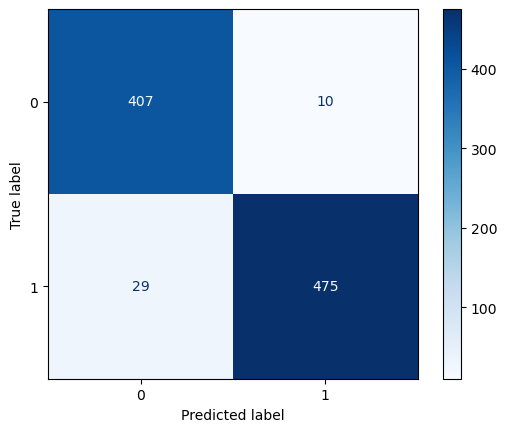

In [17]:
#Mapping a confusion matrix for fun
preds = gs_tvec.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'Blues');

In [31]:
#Fitting a TfidVectorizer, Logistic Regression, with a GridSearchCV and lemmatized data

#Instantiating TfidVectorizer and including bigrams this time
tvec =TfidfVectorizer(stop_words=sw, ngram_range=(1,2))

#Instantiating Logistic Regression
logreg = LogisticRegression(random_state=2024)
    
#Building a pipe for preprocessing
tvec_logreg_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

#Creating a range of hyperparameters to test
tvec_logreg_params = {
    'tvec__preprocessor': [None, lemmatize_reddit],
    'tvec__stop_words': [None, 'sw'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [2000, 3000, 4000, 5000, None]
}

#Instantiating GridSearchCV
gs_logreg_tvec = GridSearchCV(tvec_logreg_pipe, tvec_logreg_params, cv=5, n_jobs=4)

#Fitting the data to the new estimator
gs_logreg_tvec.fit(X_train, y_train)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000, None],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__preprocessor': [None,
                                                <function lemmatize_reddit at 0x143926f20>],
                         'tvec__stop_words': [None, 'sw']})

In [32]:
#Checking the scores --> We're back up! 96.8%
gs_logreg_tvec.score(X_train, y_train), gs_logreg_tvec.score(X_test, y_test)

(0.9800941006152732, 0.9685124864277959)

Text(0.0, 1.0, 'Prediction ConsufionMatrix: Tfid-LogisticRegression-GridSearchCV & Lem')

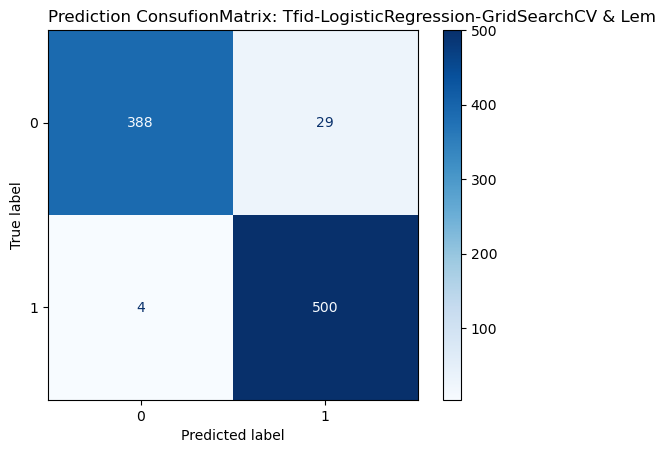

In [50]:
#Mapping my predictions to a Confusion Matrix
preds_gs_logreg_tvec = gs_rf_tvec_lem.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds_gs_logreg_tvec, cmap = 'Blues');
plt.title('Prediction ConsufionMatrix: Tfid-LogisticRegression-GridSearchCV & Lem', loc='left')

In [36]:
#Fitting a TfidVectorizer with a RandomForest and a GridSearchCV
#Instantiating the RandomForest
rf = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    max_features=6,
    random_state=2024
)
    
#Building a pipe for preprocessing
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

#Putting in a range of parameters to test on
tvec_rf_params = {
    'tvec__stop_words': [None, 'sw'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [2000, 3000, 4000, 5000, None]
}

#Fitting the GridSearchCV
gs_rf_tvec = GridSearchCV(tvec_rf_pipe, tvec_rf_params, cv=5, n_jobs=4)
gs_rf_tvec.fit(X_train, y_train)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000, None],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'sw']})

In [55]:
#Getting accuracy score --> Back down!
gs_rf_tvec.score(X_train, y_train), gs_rf_tvec.score(X_test, y_test)

(1.0, 0.9576547231270358)

In [33]:
#Fitting a Tfid with a RandomForest and a GridSearchCV, with Lemmatized Data

#Creating hyper parameters with a lemmatizer
tvec_rf_params = {
    'tvec__preprocessor': [None, lemmatize_reddit],
    'tvec__stop_words': [None, 'sw'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [2000, 3000, 4000, 5000, None]
}

#Instantiating and fitting with GridSearchCV
gs_rf_tvec = GridSearchCV(tvec_rf_pipe, tvec_rf_params, cv=5, n_jobs=4)
gs_rf_tvec.fit(X_train, y_train)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000, None],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__preprocessor': [None,
                                                <function lemmatize_reddit at 0x143926f20>],
                         'tvec__stop_words': [None, 'sw']})

In [51]:
#Getting accuracy score ---> still down!
print(baseline)
gs_rf_tvec.score(X_train, y_train), gs_rf_tvec.score(X_test, y_test)

0.4568403908794788


(1.0, 0.9576547231270358)

Text(0.0, 1.0, 'Prediction ConsufionMatrix: Tfid-RandomForest-GridSearchCV ')

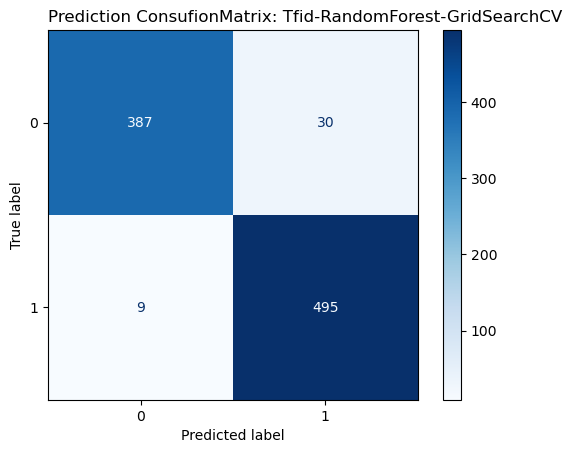

In [48]:
#Mapping it in a Confusion Matrix
preds_rf_tvec = gs_rf_tvec.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds_rf_tvec, cmap = 'Blues');
plt.title('Prediction ConsufionMatrix: Tfid-RandomForest-GridSearchCV ', loc='left')

In [25]:
gs_rf_tvec.best_params_

{'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [26]:
#Trying it again with best params above and lemmatizer
    
#Building a pipe
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

#Using just the best parameter from above
tvec_rf_params = {
    'tvec__preprocessor': [None, lemmatize_reddit],
    'tvec__stop_words': [None, 'sw'],
    'tvec__min_df': [2],
    'tvec__ngram_range': [(1,1)],
    'tvec__max_features': [2000]
}

#Fitting it again
gs_rf_tvec_lem = GridSearchCV(tvec_rf_pipe, tvec_rf_params, cv=5, n_jobs=4)
gs_rf_tvec_lem.fit(X_train, y_train)

#Scoring it and it's back up! But, not as good as the classification models earlier Tfid+LogReg+GridSearchCV+Lemma combo
gs_rf_tvec_lem.score(X_train, y_train), gs_rf_tvec_lem.score(X_test, y_test)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/skle

(1.0, 0.9641693811074918)

Text(0.0, 1.0, 'Prediction ConsufionMatrix: Tfid-RandomForest-GridSearchCV & Lem ')

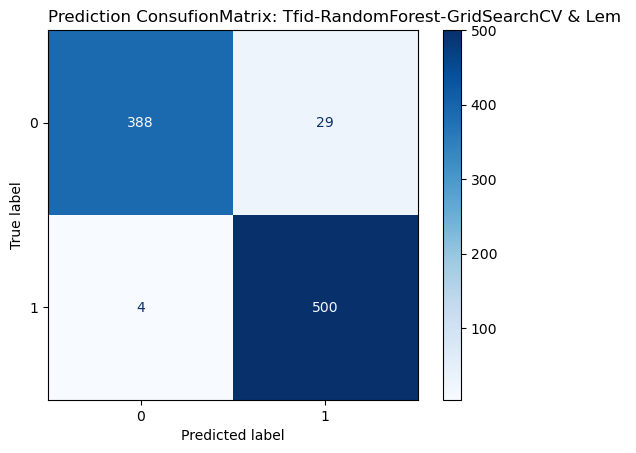

In [49]:
#Creating a ConsuionMatrix of answers
preds_rf_tvec_lem = gs_rf_tvec_lem.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds_rf_tvec_lem, cmap = 'Blues');
plt.title('Prediction ConsufionMatrix: Tfid-RandomForest-GridSearchCV & Lem ', loc='left')